# US West Coast Water Resources Tutorial

## This notebook is written by: 

Aneesh Subramanian (aneeshcs@colorado.edu) & Will Chapman (wchapman@ucsd.edu) with input from Mike DeFlorio (mdeflorio@ucsd.edu), for the NCAR ASP2021 S2S summer school

Thank NCAR CISL for the computational resources to complete this work, and the WMO S2S project for providing the data, and running the models

Please see the ["To-Do"](https://docs.google.com/document/d/1VSkZDZ_nbTqdsp-EnoMfbNKTt0sOCO3gK_1milBPQ8A/edit?usp=sharing) document to keep track of progress. 


# Table of Contents:
* [Overarching Project Goal](#first-bullet)
* [Read Control Run](#second-bullet)
* [Make a plot of the IVT](#third-bullet)
* [Plot Spread / Skill Time Series](#fourth-bullet)
* [Open the Obs files](#fifth-bullet)
* [Plot the weighted Spread](#sixth-bullet)
* [Add uncertainty to RMSE Spread metric](#seventh-bullet)

# Overarching Goal <a class="anchor" id="first-bullet"></a>

The Goal of the US West Coast S2S prediction project is to leverage the WMO S2S Database and study how some specific case studies of extreme precipitation, heatwaves and atmospheric rivers (ARs) over the NE Pacific were forecast on subseasonal timescales. We will study certain atmospheric river case studies that lead to the [Oroville Dam crisis](https://en.wikipedia.org/wiki/Oroville_Dam_crisis). The same year (2017) spring season, there were couple of heat waves over Sierra Nevada that lead to a lot of snow melt in the region and further water managerment problems downstream.
This notebook estabilishes a baseline "simple" python code to plot integrated water vapor for the above mentioned atmospheric river cases and also evaluate the skill of the ECMWF Forecast model against ERA5 reanalysis. 

 The tasks would be to quantify at what lead was there skill in the prediction of these AR events, how well could the precursor patterns of these AR events be predicted, how well could the precipitation associated with these AR events be predicted. Further, evaluate the forecast skill of the heatwaves in Spring that lead to snow melt. Once done, you can then explore what were the largescale drivers of these events and how well were they predicted on S2S timescales. 
 
 Data available for analysis (ECMWF S2S Forecast data - Dec 2016 to May 2017 and ERA5 reanalysis)
 - Integrated water vapor transport (vertically integrated moisture transport)
 - Precipitation
 - Column integrated water vapor
 - 2m temperature maximum over 6 hour period

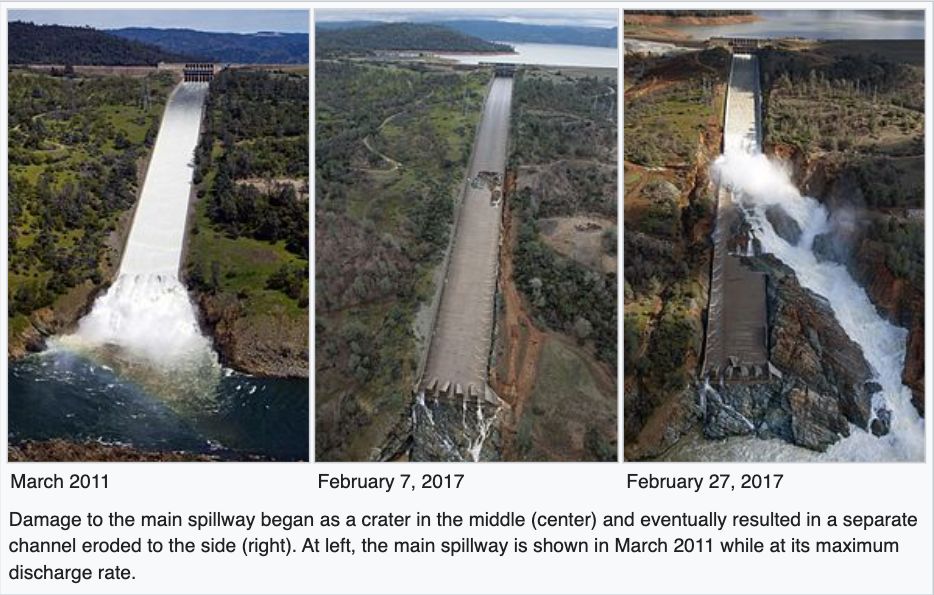

In [1]:
%matplotlib inline
import xarray as xr
import glob
import copy
import numpy as np
from datetime import datetime
import os
import sys 

# # you need intake-esm V 2020.11.4 and intake V 0.6.0

# # import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import fsspec
import xskillscore as xs

import cmocean
import xskillscore as xs


# Read Control Run <a class="anchor" id="second-bullet"></a>

In [13]:
d = '/glade/scratch/acsubram/S2S_Database/IVT_20170202.nc'
dsfcst = xr.open_dataset(d)
dsfcst

<xarray.Dataset>
Dimensions:     (latitude: 121, longitude: 240, number: 50, step: 47)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 0 days 1 days 2 days ... 45 days 46 days
  * latitude    (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude   (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    valid_time  (step) datetime64[ns] ...
Data variables:
    ivt         (number, step, latitude, longitude) float32 ...

In [14]:
ivt = dsfcst['ivt']
lat = dsfcst['latitude']
lon = dsfcst['longitude']

# Make a plot of the IVT <a class="anchor" id="third-bullet"></a>

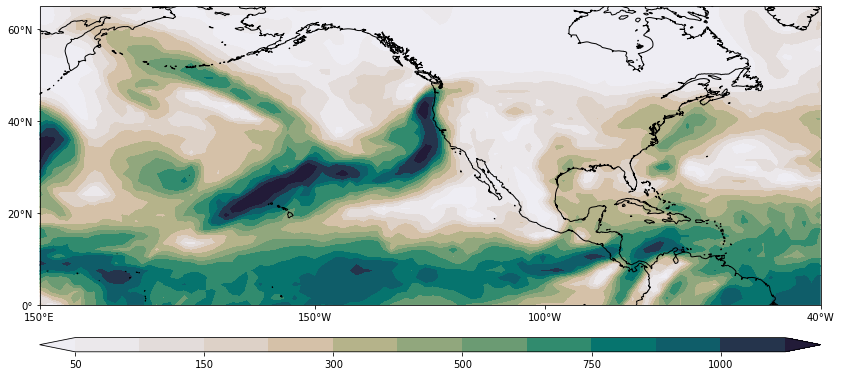

In [16]:
ivt_plt_sample = ivt[1,4,:,:]
mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([150, 320 , 0, 65], ccrs.PlateCarree())
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt_sample , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')

In [5]:
sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT*.nc'))

['/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161201.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161202.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161203.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161204.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161205.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161206.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161207.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161208.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161209.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161210.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161211.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161212.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161213.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161214.nc',
 '/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT_20161215.

## Plot Spread / Skill Time Series <a class="anchor" id="fourth-bullet"></a>

## Open the Obs files: <a class="anchor" id="fifth-bullet"></a>

In [6]:
fillys = len(sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT*.nc')))
bb = xr.open_dataset(sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT*.nc'))[0])
lat = np.array(bb['latitude'])
lon = np.array(bb['longitude'])


compivt = np.zeros([fillys,lat.shape[0],lon.shape[0]])
comptime = np.zeros([fillys],dtype='datetime64[ns]')
for ii in range(fillys):
    bb = xr.open_dataset(sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT*.nc'))[ii])
    ivt = np.array(bb['ivt'])
    compivt[ii,:,:] = ivt
    comptime[ii] = np.array(bb['time'])
    
    
IVT_obs = xr.Dataset(
    {
        "IVT": (["time","latitude", "longitude"],compivt),    
    },
    coords={
        "time":comptime,
        "latitude":lat,
        "longitude":lon,
    },)

## Now Plot the weighted Spread <a class="anchor" id="sixth-bullet"></a>

This next cell is gathering the forecasts and observations into two seperate Xarray structures so that they can be compared

In [7]:
%%time
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
# Find your list of forecast files: 
##################################################################
FilList = sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/IVT*2*.nc'))
FilList = FilList[0:30] # this is as far out as we can go
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
# Subset for region of interest like so:
##################################################################

latwant=[65,25] # North-to-South
lonwant=[140,240] # degrees East ... But what does that mean on a globe really? 
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#create a weight matrix to scale by latitude (higher latitude = less area)
##################################################################
df = xr.open_dataset(FilList[0])
weight_r = np.cos(np.deg2rad(df.latitude))
_, weight_r = xr.broadcast(df,weight_r)
weight_r  = weight_r.isel(step=0,number=0)
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#initialize array's 
##################################################################
shpp =np.array(df['ivt']).shape
compiled_forecast = np.zeros([len(FilList),shpp[0],shpp[1],shpp[2],shpp[3]])
compiled_obs = np.zeros([len(FilList),shpp[1],shpp[2],shpp[3]])
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



for yy,dd  in enumerate(FilList):
    print('Doing Forecast',dd)
    df = xr.open_dataset(dd)
    compiled_forecast[yy,:,:,:,:] = np.array(((df['ivt'])))## - np.expand_dims(OBS_clim,axis=1))) This is where you subtract lead time bias Aneesh! 
    
    observations = IVT_obs.sel(time=slice(df.valid_time.values[0],df.valid_time.values[-1])).IVT
    
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ##################################################################
    ##################################################################
    
    #HAVE TO FLIP THE OBS LATITUDE!
#     observations = observations.reindex(latitude=list(reversed(observations.latitude)))
    ##################################################################
    ##################################################################
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    compiled_obs[yy,:,:,:] = observations ##
#     if yy == 3:
#         break
    
leader = np.arange(0,47,1)
lat = np.array(df.latitude)
lon = np.array(df.longitude)
number = np.arange(0,50,1)
issued=np.arange(0,len(FilList),1)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
# # compiled forecasts in Xarray's:
##################################################################

C_for = xr.Dataset(
    {
        "ivt": (["issued","ensemble","lead","latitude", "longitude"],compiled_forecast),
        
    },
    coords={
        "issued":issued,
        "lead":leader,
        "ensemble":number,
        "latitude":lat,
        "longitude":lon,
    },)

C_for.attrs["title"] = "EC S2S IVT Forecast "
# C_obs.ivt.attrs['units'] = 'kg m-1 s-1'
C_for.ivt.attrs['standard_name']='Integrated Vapor Transport'
C_for.ivt.attrs['long_name']='Integrated Vapor Transport'
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
########################################################
#compiled obs in Xarray's:
########################################################
lat = np.array(df.latitude)
lon = np.array(df.longitude)
C_obs = xr.Dataset(
    {
        "ivt": (["issued","lead","latitude", "longitude"],compiled_obs),
        
    },
    coords={
        "issued":issued,
        "lead":leader,
        "latitude":lat,
        "longitude":lon,
    },)

C_obs.attrs["title"] = "EC S2S IVT Forecast "
C_obs.ivt.attrs['units'] = 'kg m-1 s-1'
C_obs.ivt.attrs['standard_name']='Integrated Vapor Transport'
C_obs.ivt.attrs['long_name']='Integrated Vapor Transport'
########################################################
########################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
##################################################################
#subset for region:
##################################################################
C_for_roi = C_for.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
C_obs_roi = C_obs.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
print('...do ensemble mean...')
C_for_roi_ensemean = C_for_roi.mean('ensemble')
print('....done....')
##################################################################
##################################################################
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170102.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170105.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170109.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170112.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170116.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170119.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170123.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170126.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170130.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170202.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170206.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170209.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170213.nc
Doing Forecast /glade/scratch/acsubram/S2S_Database/IVT_20170216.nc
Doing Forecast /glade/scratch/acsubram/S2S_Datab

In [8]:
#recalculate your weight matrix 
weight_r = weight_r.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
Spread= C_for_roi.ivt.std("ensemble").weighted(weight_r).mean(("latitude","longitude","issued")).data

## This is to Add Uncertainty Bounds  <a class="anchor" id="seventh-bullet"></a>
We use Xarray and Xskillscore to calculate weighted spread and rmse see below...
This takes a while to perform...

In [9]:
%%time
bsnummy= 100 #we are only iterating 100 times because it takes so long 
subset_percentage = 1. 
Spread_err = np.zeros([bsnummy,Spread.shape[0]])
RMSE_err = np.zeros([bsnummy,Spread.shape[0]])

for ii in range(bsnummy):
    if (ii % 5)==0:
        print('iteration #:',ii)
    fcs =np.random.randint(0,int((np.array(C_for.issued.max())*subset_percentage)),len(FilList)) #resample the forecasts for uncertainty... bootstrap. 
    ctm = C_for_roi.sel(issued=fcs)
    Spread_err[ii,:] = ctm.ivt.std("ensemble").weighted(weight_r).mean(("latitude","longitude","issued")).data
    
    cfm = C_for_roi_ensemean.sel(issued=fcs)
    cobs = C_obs_roi.sel(issued=fcs)
    
    RMSE_err[ii,:] = xs.rmse(cobs,cfm,dim=['issued']).ivt.weighted(weight_r).mean(("latitude","longitude")).data

iteration #: 0
iteration #: 5
iteration #: 10
iteration #: 15
iteration #: 20
iteration #: 25
iteration #: 30
iteration #: 35
iteration #: 40
iteration #: 45
iteration #: 50
iteration #: 55
iteration #: 60
iteration #: 65
iteration #: 70
iteration #: 75
iteration #: 80
iteration #: 85
iteration #: 90
iteration #: 95
CPU times: user 2min 1s, sys: 3min 16s, total: 5min 18s
Wall time: 17min 5s


## Plot Spread / Skill

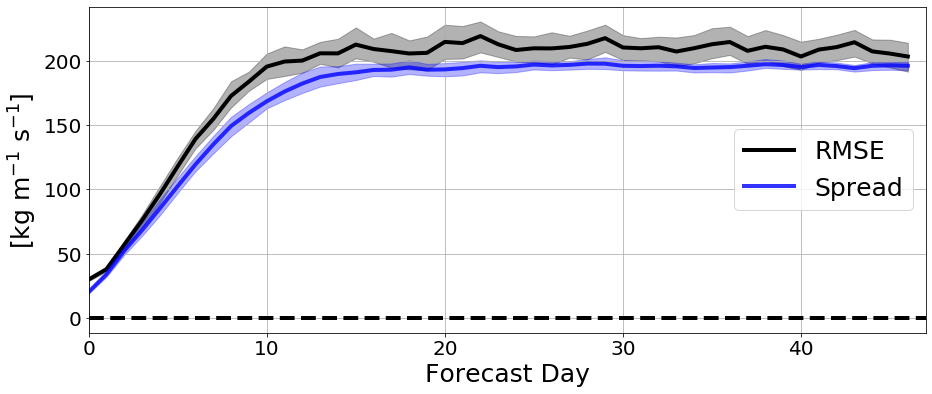

In [10]:
################################################

plt.figure(figsize=(15,6))

plt.plot(np.mean(RMSE_err,axis=0),color='k',linewidth=4,label='RMSE')
plt.fill_between(np.arange(0,47),np.percentile(RMSE_err,95,axis=0),np.percentile(RMSE_err,5,axis=0),alpha=0.3,color='k')

plt.plot(np.mean(Spread_err,axis=0),color='b',linewidth=4,label='Spread',alpha=0.8)
plt.fill_between(np.arange(0,47),np.percentile(Spread_err,99,axis=0),np.percentile(Spread_err,1,axis=0),alpha=0.3,color='b')

plt.plot([0,65],[0,0],color='k',linestyle='--',linewidth=4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0,47])
# plt.ylim([0,110])

plt.grid(True)
plt.xlabel('Forecast Day',fontsize=25)
plt.ylabel('[kg m$^{-1}$ s$^{-1}$]',fontsize=25)
plt.legend(fontsize=25)

path_to_save = "/glade/work/wchapman/ECMWF_20C/notebooks/Reproduce_Weishemer/Figures/testbad.png"
# plt.savefig(path_to_save,dpi=300,bbox_inches='tight')

plt.show()


## Plotting

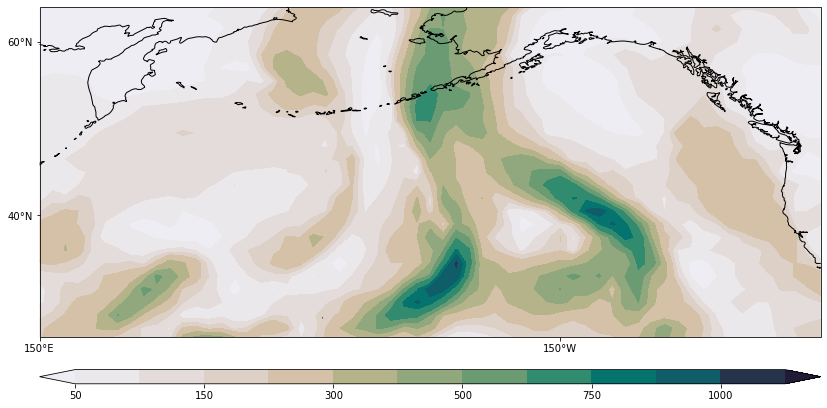

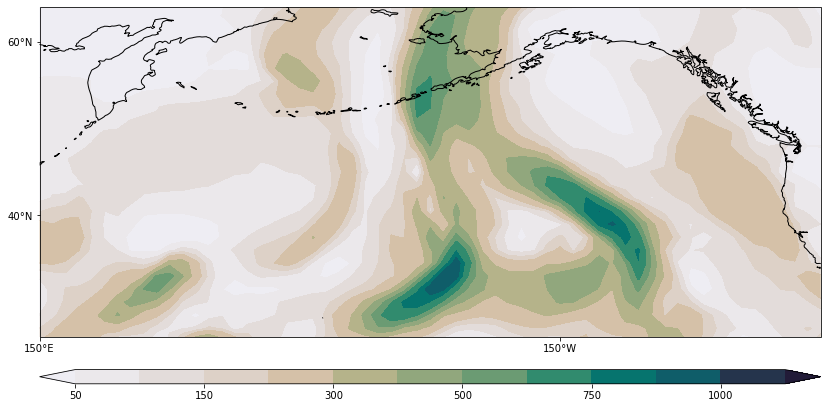

In [11]:
ivt_plt = np.array(C_for_roi.sel(issued=0,lead=0).ivt.mean('ensemble'))
lon = np.array(C_for_roi['longitude'])
lat = np.array(C_for_roi['latitude'])

mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([150, 240 , 25, 65], ccrs.PlateCarree())
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([150, 240 , 26, 64], ccrs.PlateCarree())


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')

###################################################################
###################################################################

###################################################################
ivt_plt = np.array(C_obs_roi.sel(issued=0,lead=0).ivt)
lon = np.array(C_obs_roi['longitude'])
lat = np.array(C_obs_roi['latitude'])

mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([150, 240 , 26, 64], ccrs.PlateCarree())


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')
